In [9]:
from pyteomics import mzml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pandas as pd
import SIMSIToolBox
from scipy import interpolate
import scipy.stats as stats
import scipy


def parseMzML_IM(filename):
    reader = mzml.read(filename)
    data = {}
    for temp in reader:
        data[(
        float(temp["scanList"]["scan"][0]["scan start time"]), float(temp["scanList"]["scan"][0]["ion mobility drift time"]))] = {
        mz: val for mz, val in zip(temp["m/z array"], temp["intensity array"])}
        
    reader.close()

    return data

C = 0.001 * 1.41
f = 66.0
mGas = 28.00614

def dt2ccs(fn):
    
    conv = pd.read_csv(fn,header=7)

    x = conv["* tc"].values
    y = conv["OmegaC"].values
    
    starting = [100,1.0,2.0]
    
    t2O = lambda t,c: c[0] * (c[2] + t) ** c[1]
    
    obj = lambda c: np.sum(np.square(np.subtract(y,[t2O(t,c) for t in x])))
    
    sol = scipy.optimize.minimize(obj,x0=starting)
    
    c = sol.x
            
    omega_corr = lambda mz,dt: t2O(dt - C * np.sqrt(mz),c) * 1 * np.sqrt((1/mz + 1/mGas))
    
    return omega_corr


def getDriftogram(mz,data,rtRange,ppm):
    
    minDrift = min([x[1] for x in data])
    maxDrift = max([x[1] for x in data])
    
    numBins = len(set([x[1] for x in data]))
    
    driftBins = np.linspace(minDrift,maxDrift,numBins)
    driftogram = np.zeros(numBins)
    
    delta = ppm * mz / 1e6
    minMz = mz - delta
    maxMz = mz + delta
    for (rt,dt),spec in data.items():
        if rt > rtRange[0] and rt < rtRange[1]:
            for mz2,i in spec.items():
                if mz2 > minMz and mz2 < maxMz:
                    temp = np.abs(driftBins-dt)
                    index = temp.argmin()
                    driftogram[index] += i
    
    return driftogram,driftBins



In [3]:
datadir = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/ims/"

In [4]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
files

['20210326_10.mzML', '20210326_11.mzML']

In [5]:
data = {file:parseMzML_IM(datadir + file) for file in files}

In [6]:
targets = pd.read_csv("X:/MSI_Shared_Data/13CImagingManuscript/raw_data/non-perfused/desi/30092022_desi_targets_annotated.csv")
targets

,datasetName,formula,adduct,chemMod,ion,mz,moleculeNames,moleculeIds,meanM0,clean,for_paper,ccs
0,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C32H36N4O5,M-H,NaN,C32H36N4O5-H-,555.261215,Quinidine barbiturate,HMDB0015436,0.999988,1,0,-1.0
1,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C33H36N2O6,M-H,NaN,C33H36N2O6-H-,555.249982,Dipiperamide C,HMDB0039457,0.999691,1,0,-1.0
2,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C14H28O2,M-H,NaN,C14H28O2-H-,227.201575,"12-Methyltridecanoic acid, Hexanal octane-1,3-...","HMDB0031072, HMDB0032318, HMDB0000806, HMDB000...",0.999609,1,0,-1.0
3,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C3H6O3,M-H,NaN,C3H6O3-H-,89.024339,"Monoethyl carbonate, Dimethyl carbonate, Dihyd...","HMDB0031232, HMDB0029580, HMDB0001882, HMDB000...",0.999546,1,0,-1.0
4,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C17H34O2,M-H,NaN,C17H34O2-H-,269.248525,"Nonyl octanoate, Heptadecanoic acid, (S)-14-Me...","HMDB0034131, HMDB0002259, HMDB0031067, HMDB003...",0.999047,1,0,-1.0
5,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C15H30O2,M-H,NaN,C15H30O2-H-,241.217225,"Dodecyl propionate, Hexyl nonanoate, Pentadeca...","HMDB0032250, HMDB0032328, HMDB0000826, HMDB003...",0.998841,1,0,-1.0
6,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C19H22O3,M-H,NaN,C19H22O3-H-,297.149540,"Gravelliferone, 5-Hydroxy-7-(4-hydroxyphenyl)-...","HMDB0030729, HMDB0033711, HMDB0034054, HMDB004...",0.997415,1,0,-1.0
7,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C21H26O3,M-H,NaN,C21H26O3-H-,325.180840,"Isoacitretin, Acitretin","HMDB0003039, HMDB0014602",0.996826,1,0,-1.0
8,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C16H32O2,M-H,NaN,C16H32O2-H-,255.232875,"Butyl dodecanoate, Dodecyl butyrate, Hexyl dec...","HMDB0032065, HMDB0032249, HMDB0032324, HMDB000...",0.995917,1,1,168.7
9,20220930_01_202w145h_05H_mt_tumor_brain1-5_12C...,C10H14N5O7P,M-H,NaN,C10H14N5O7P-H-,346.055729,"Adenosine monophosphate, 2'-Deoxyguanosine 5'-...","HMDB0000045, HMDB0001044, HMDB0003540, HMDB001...",0.994711,1,1,174.1


In [7]:
driftograms = {file:{} for file in data}
ccs_matches = {}
for index,row in targets.iterrows():
    if row["for_paper"] > 0.5:
        ccs_matches[row["formula"]] = row["ccs"]
        _,_,nC = SIMSIToolBox.getMzsOfIsotopologues(row["formula"],"C")
        mzs = []
        for x in range(nC+1):
            mzs.append(row["mz"] + 1.00336 * x)

        for file in data:
            rts = list(set([x[0] for x in data[file]]))
            rts.sort()
            rtRange = [rts[0],rts[-1]]
            driftograms[file][row["formula"]] = {}
            for mz in mzs:
                driftograms[file][row["formula"]][mz] = getDriftogram(mz,data[file],rtRange,20)
        print(index)
    

8
9
14
19


C16H32O2 0 169.69110501217006
C16H32O2 1 169.65743283471136
C16H32O2 2 170.84918560890532
C16H32O2 3 169.59084137632942
C16H32O2 4 174.4554259756423
C16H32O2 5 169.5252349388519
C16H32O2 6 169.49279419643173
C16H32O2 7 170.68461419057496
C16H32O2 8 169.4286242109242
C16H32O2 9 169.39688970619216
C16H32O2 10 169.3653854171447
C16H32O2 11 169.33410880903594
C16H32O2 12 169.3030573842845
C16H32O2 13 170.4949264275771
C16H32O2 14 170.46410282526773
C16H32O2 15 169.2112297776638
C16H32O2 16 170.40311165169098
C10H14N5O7P 0 171.03550020410862
C10H14N5O7P 1 168.59791097790293
C10H14N5O7P 2 172.20593445155467
C10H14N5O7P 3 168.56033647803653
C10H14N5O7P 4 170.95931218219457
C10H14N5O7P 5 168.52317262582824
C10H14N5O7P 6 170.9218411520007
C10H14N5O7P 7 172.1113575506485
C10H14N5O7P 8 169.67658748038244
C10H14N5O7P 9 167.24155059680248
C10H14N5O7P 10 167.2236403422714
C18H36O2 0 177.36958462056475
C18H36O2 1 178.55858248566616
C18H36O2 2 177.31190342018303
C18H36O2 3 177.2833537837078
C18H36O2 4

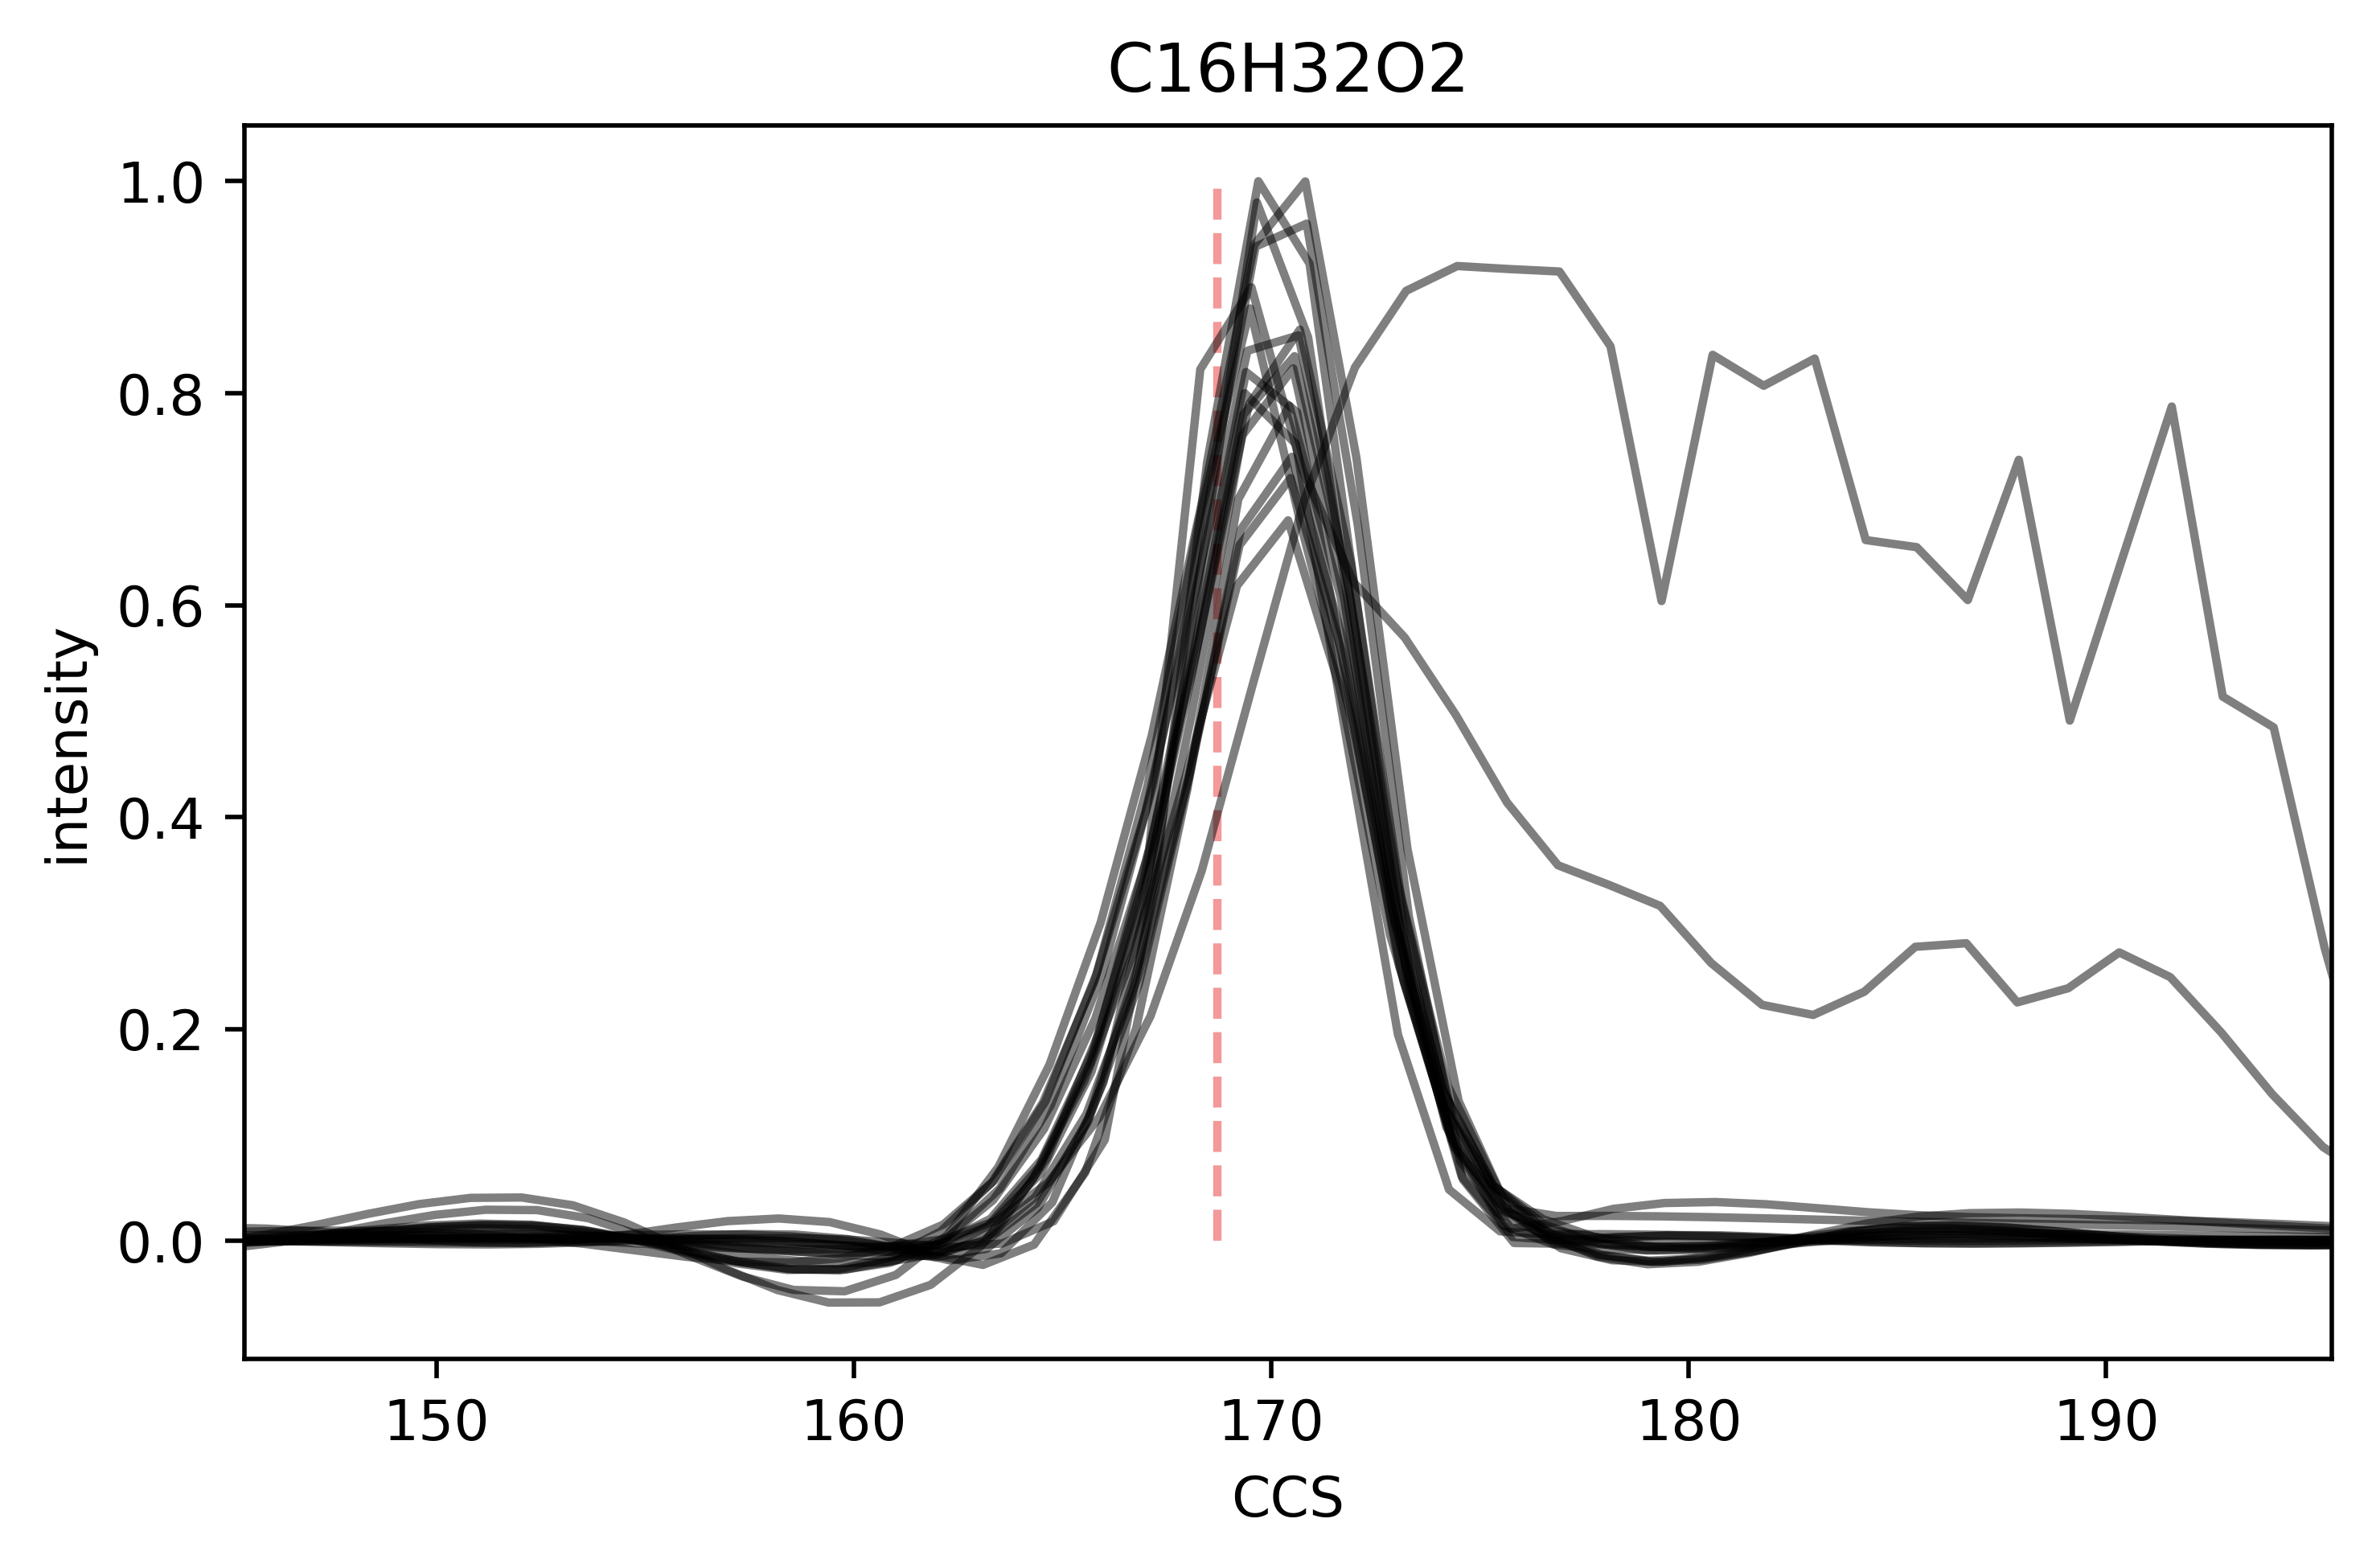

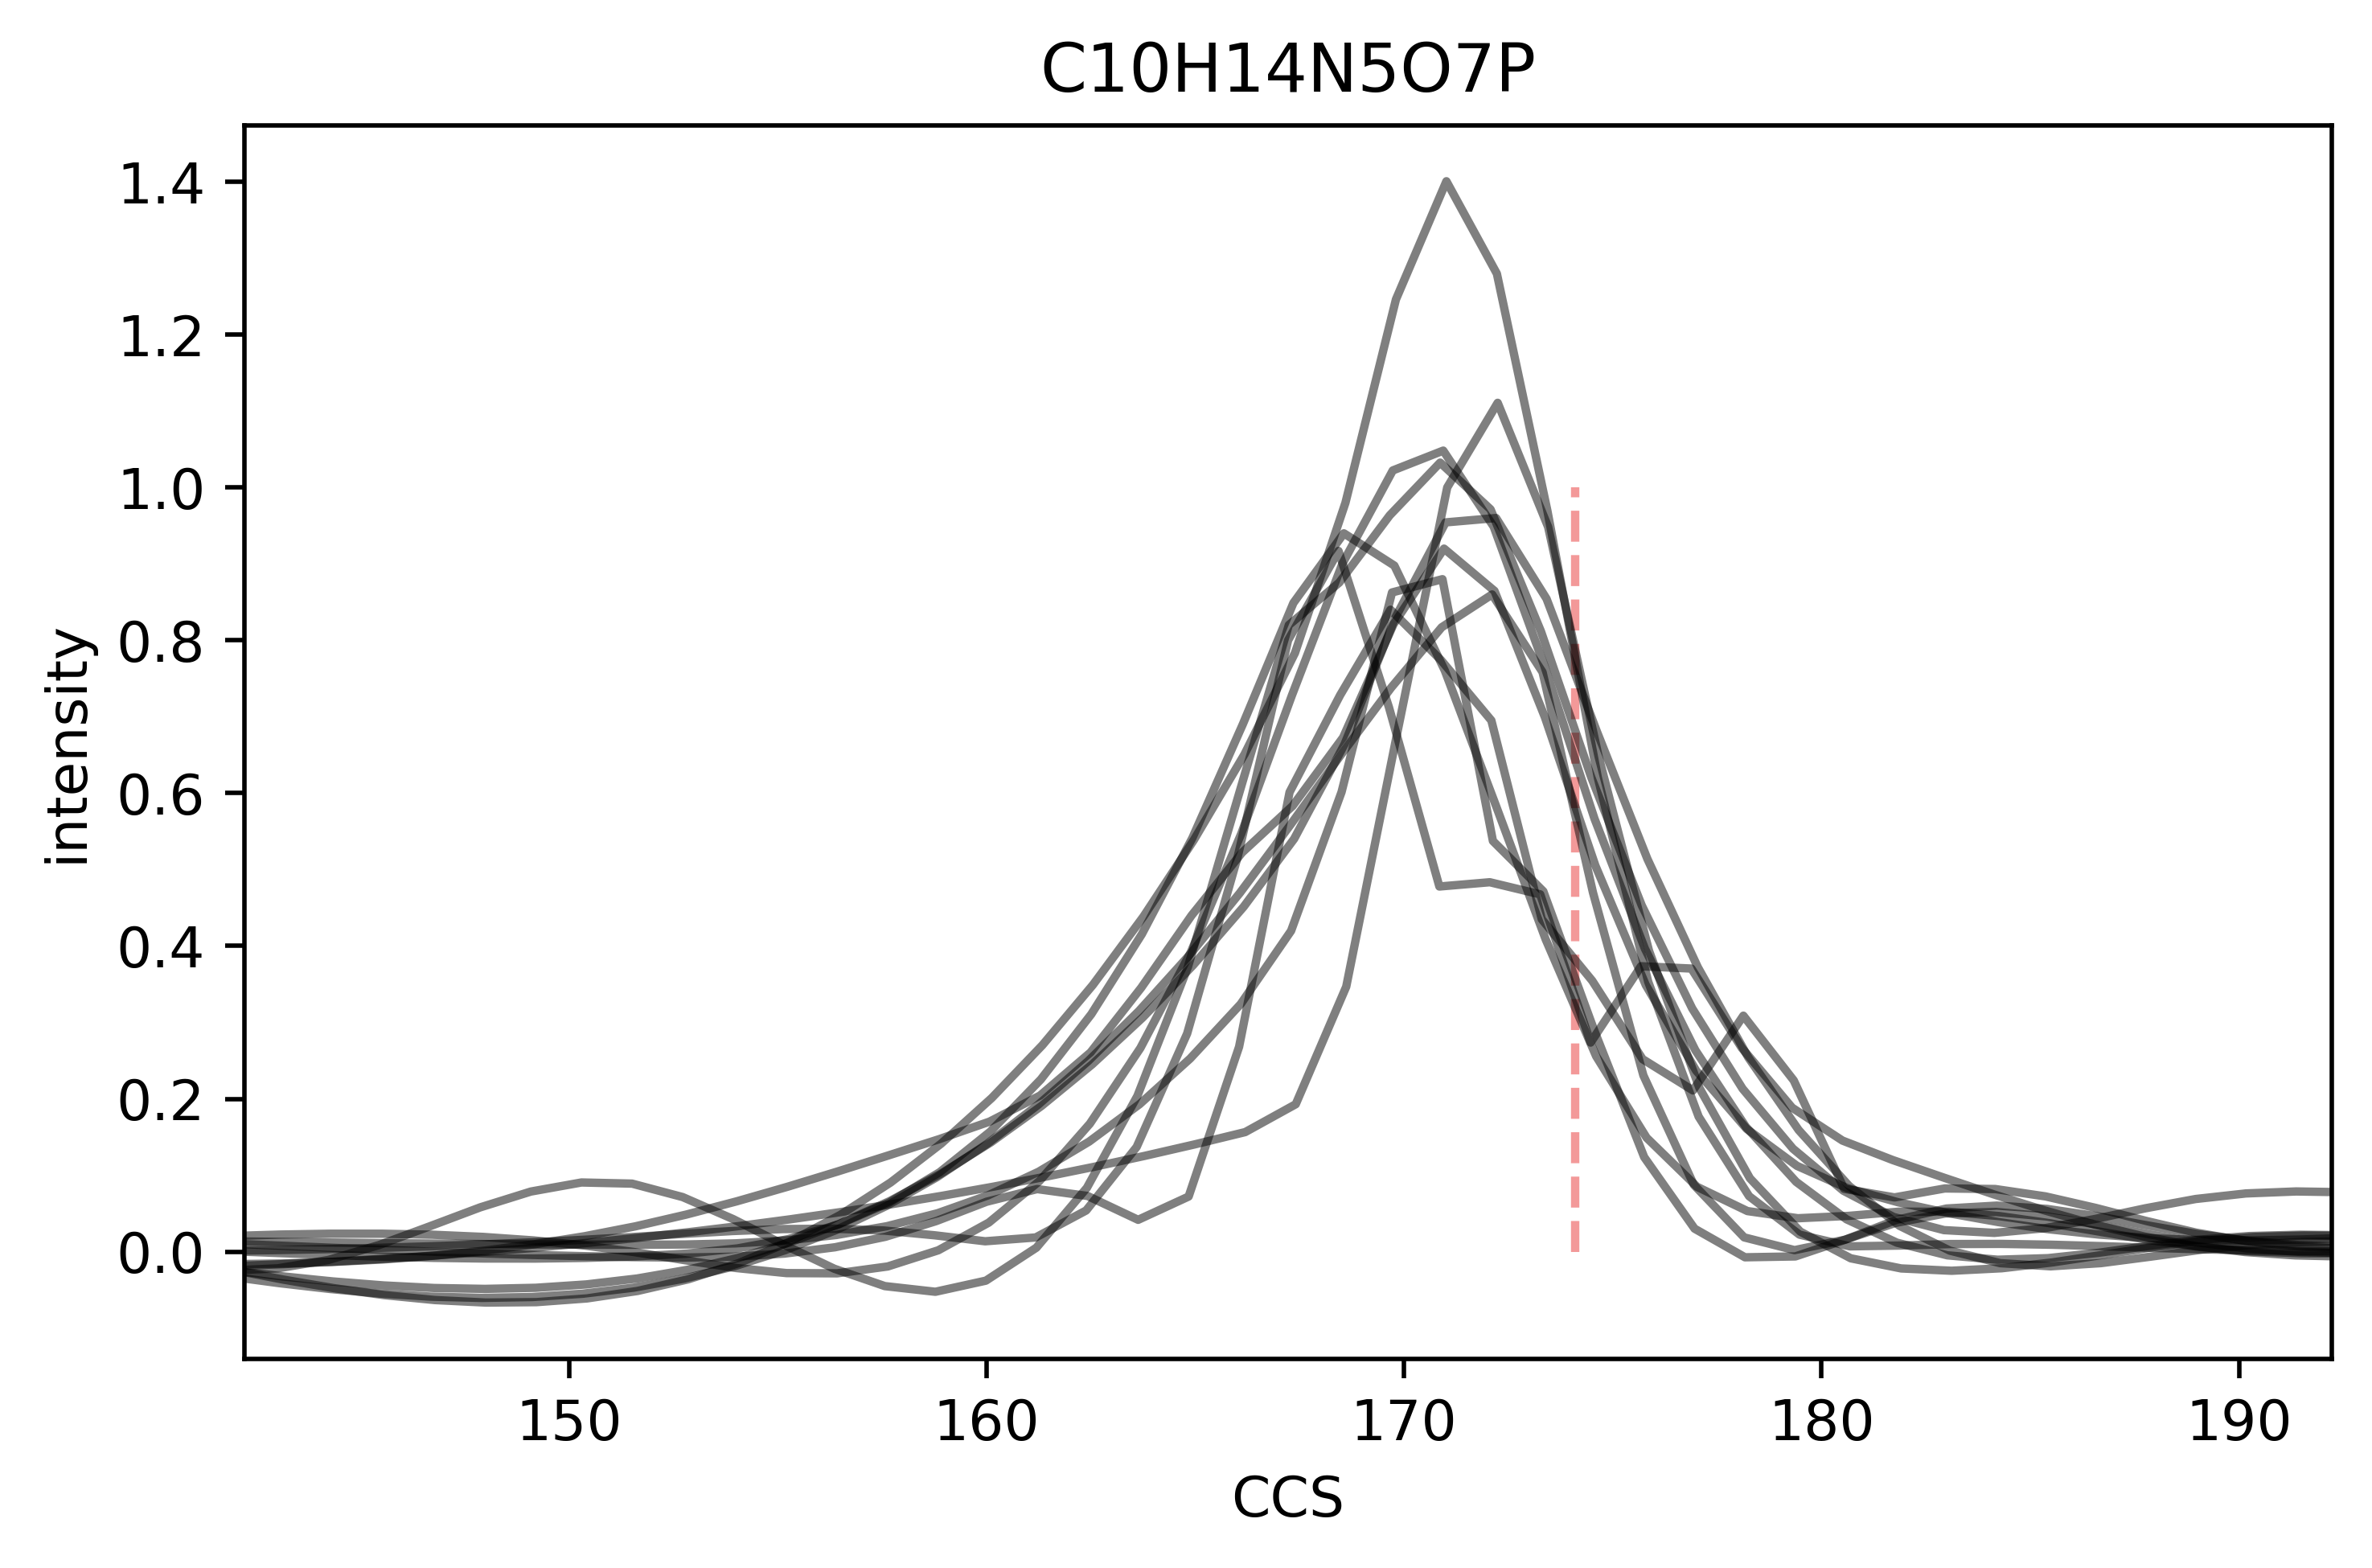

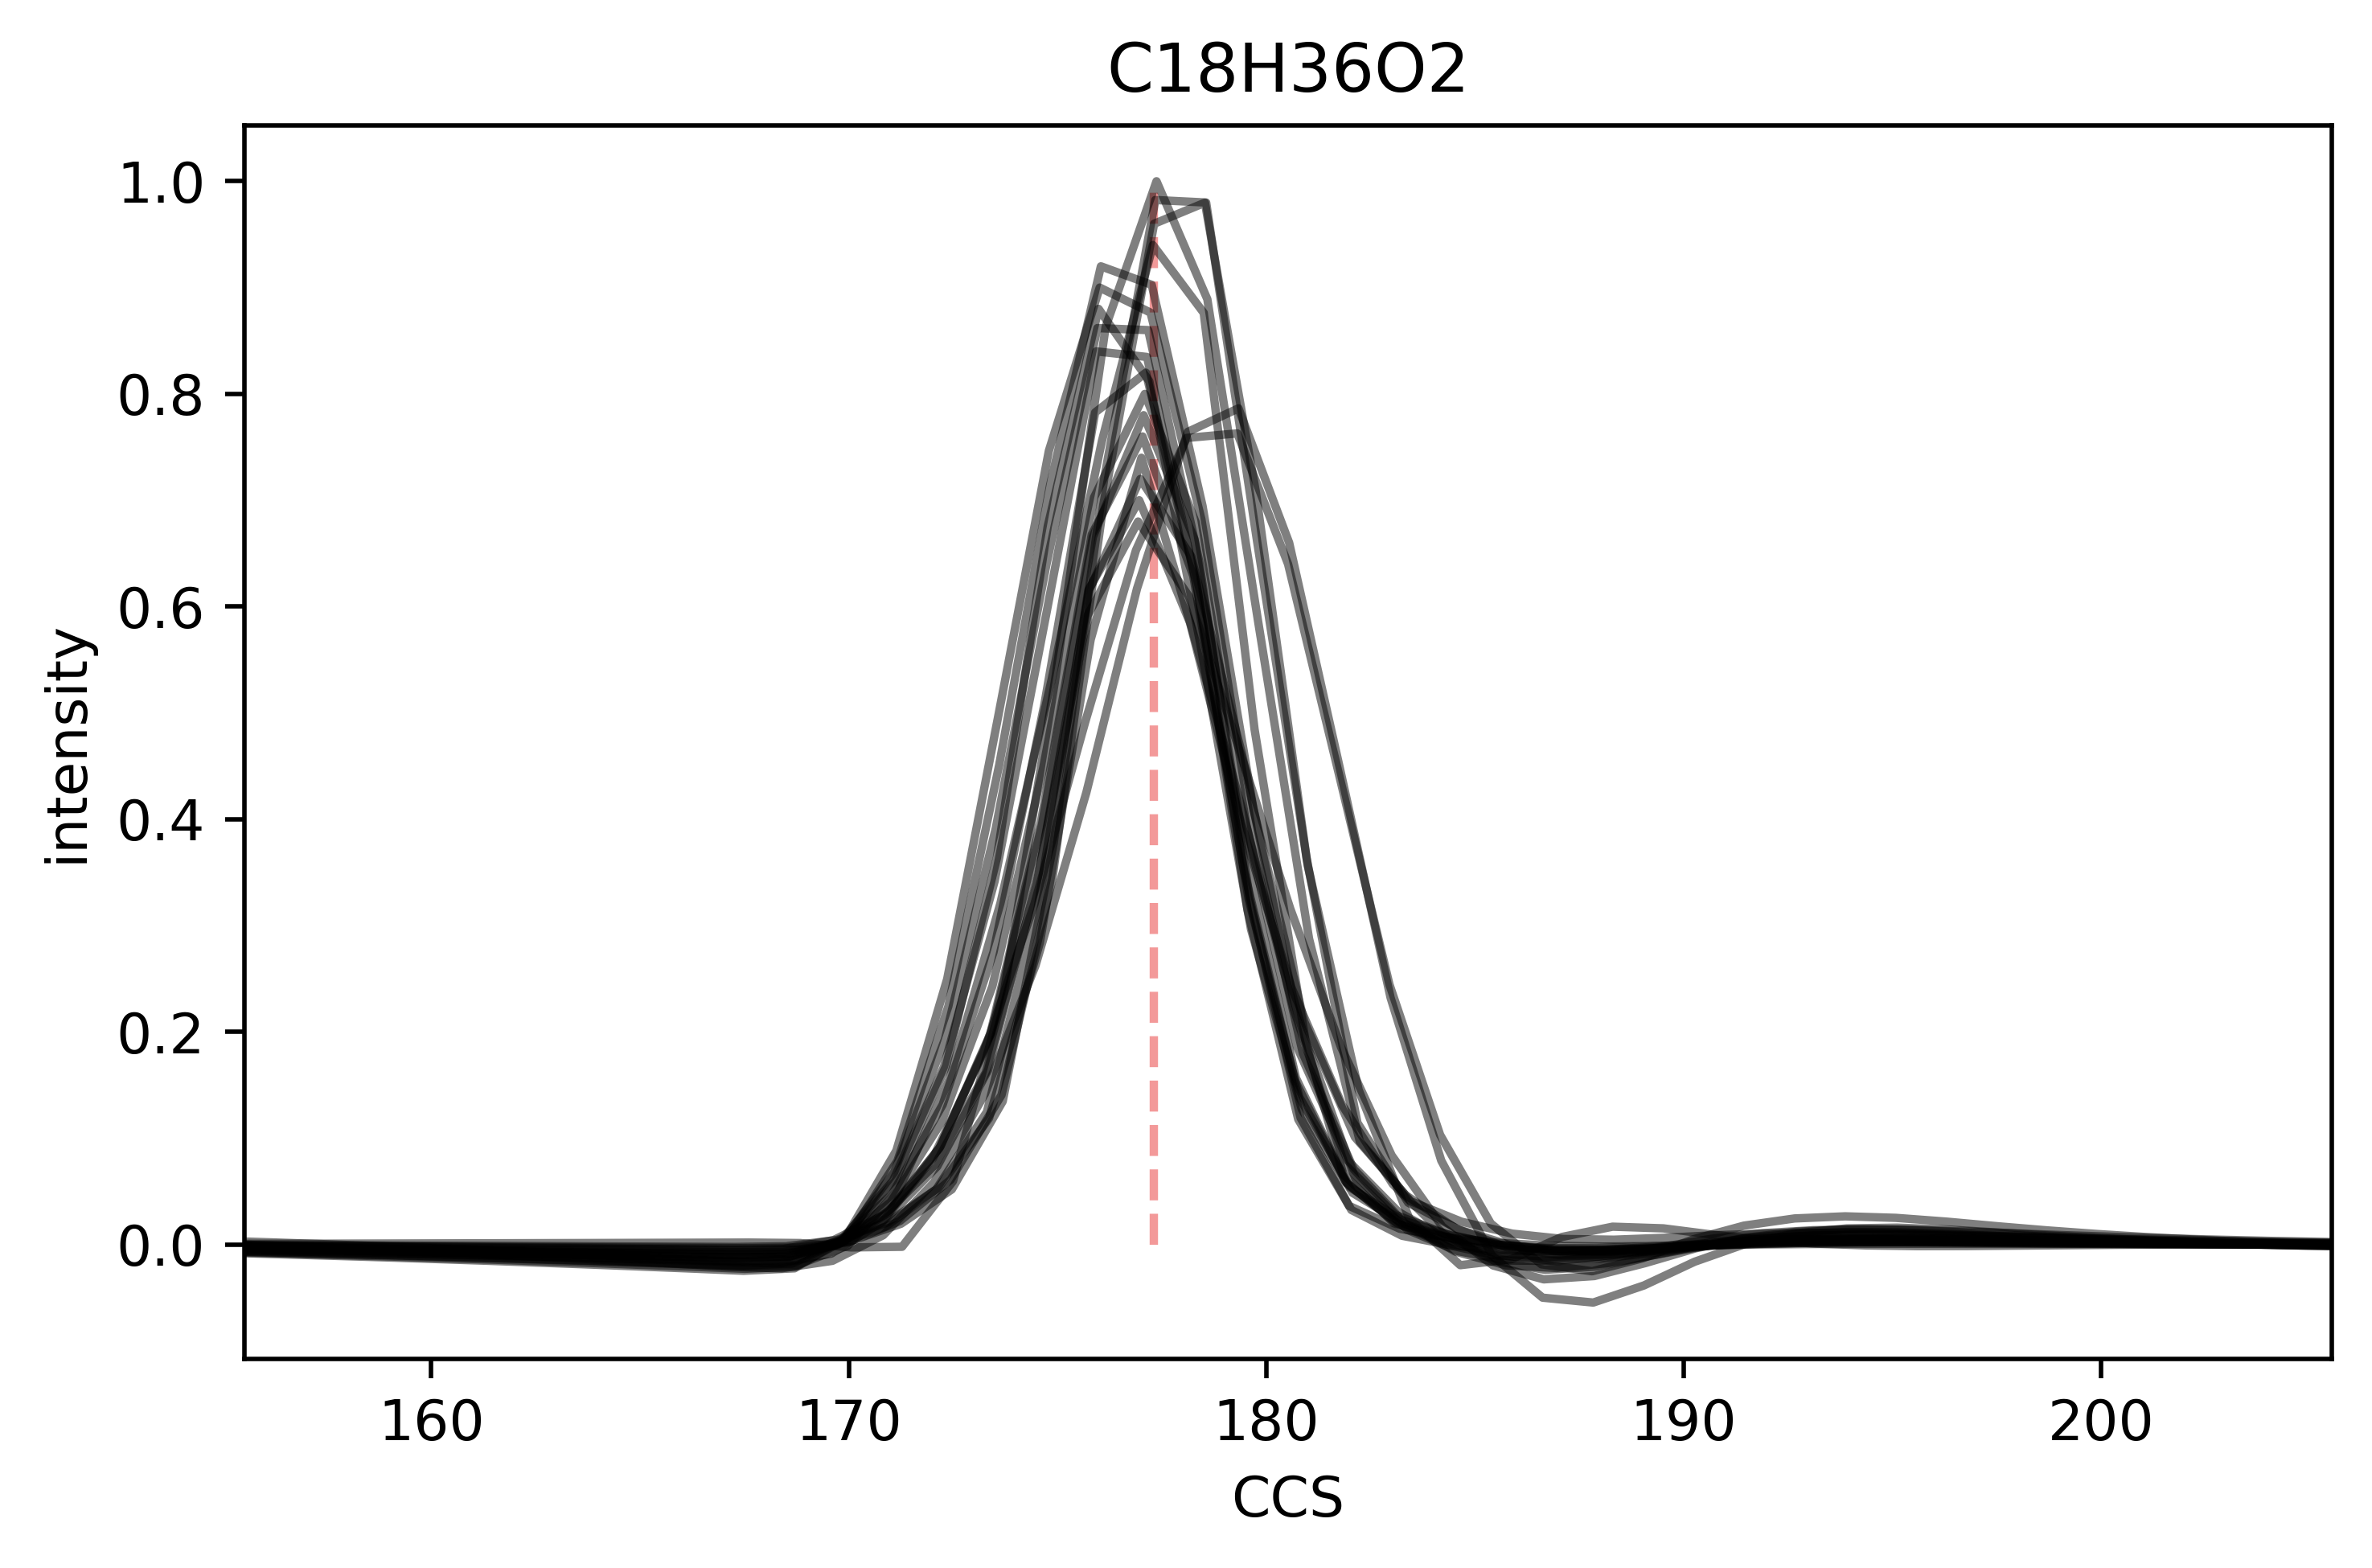

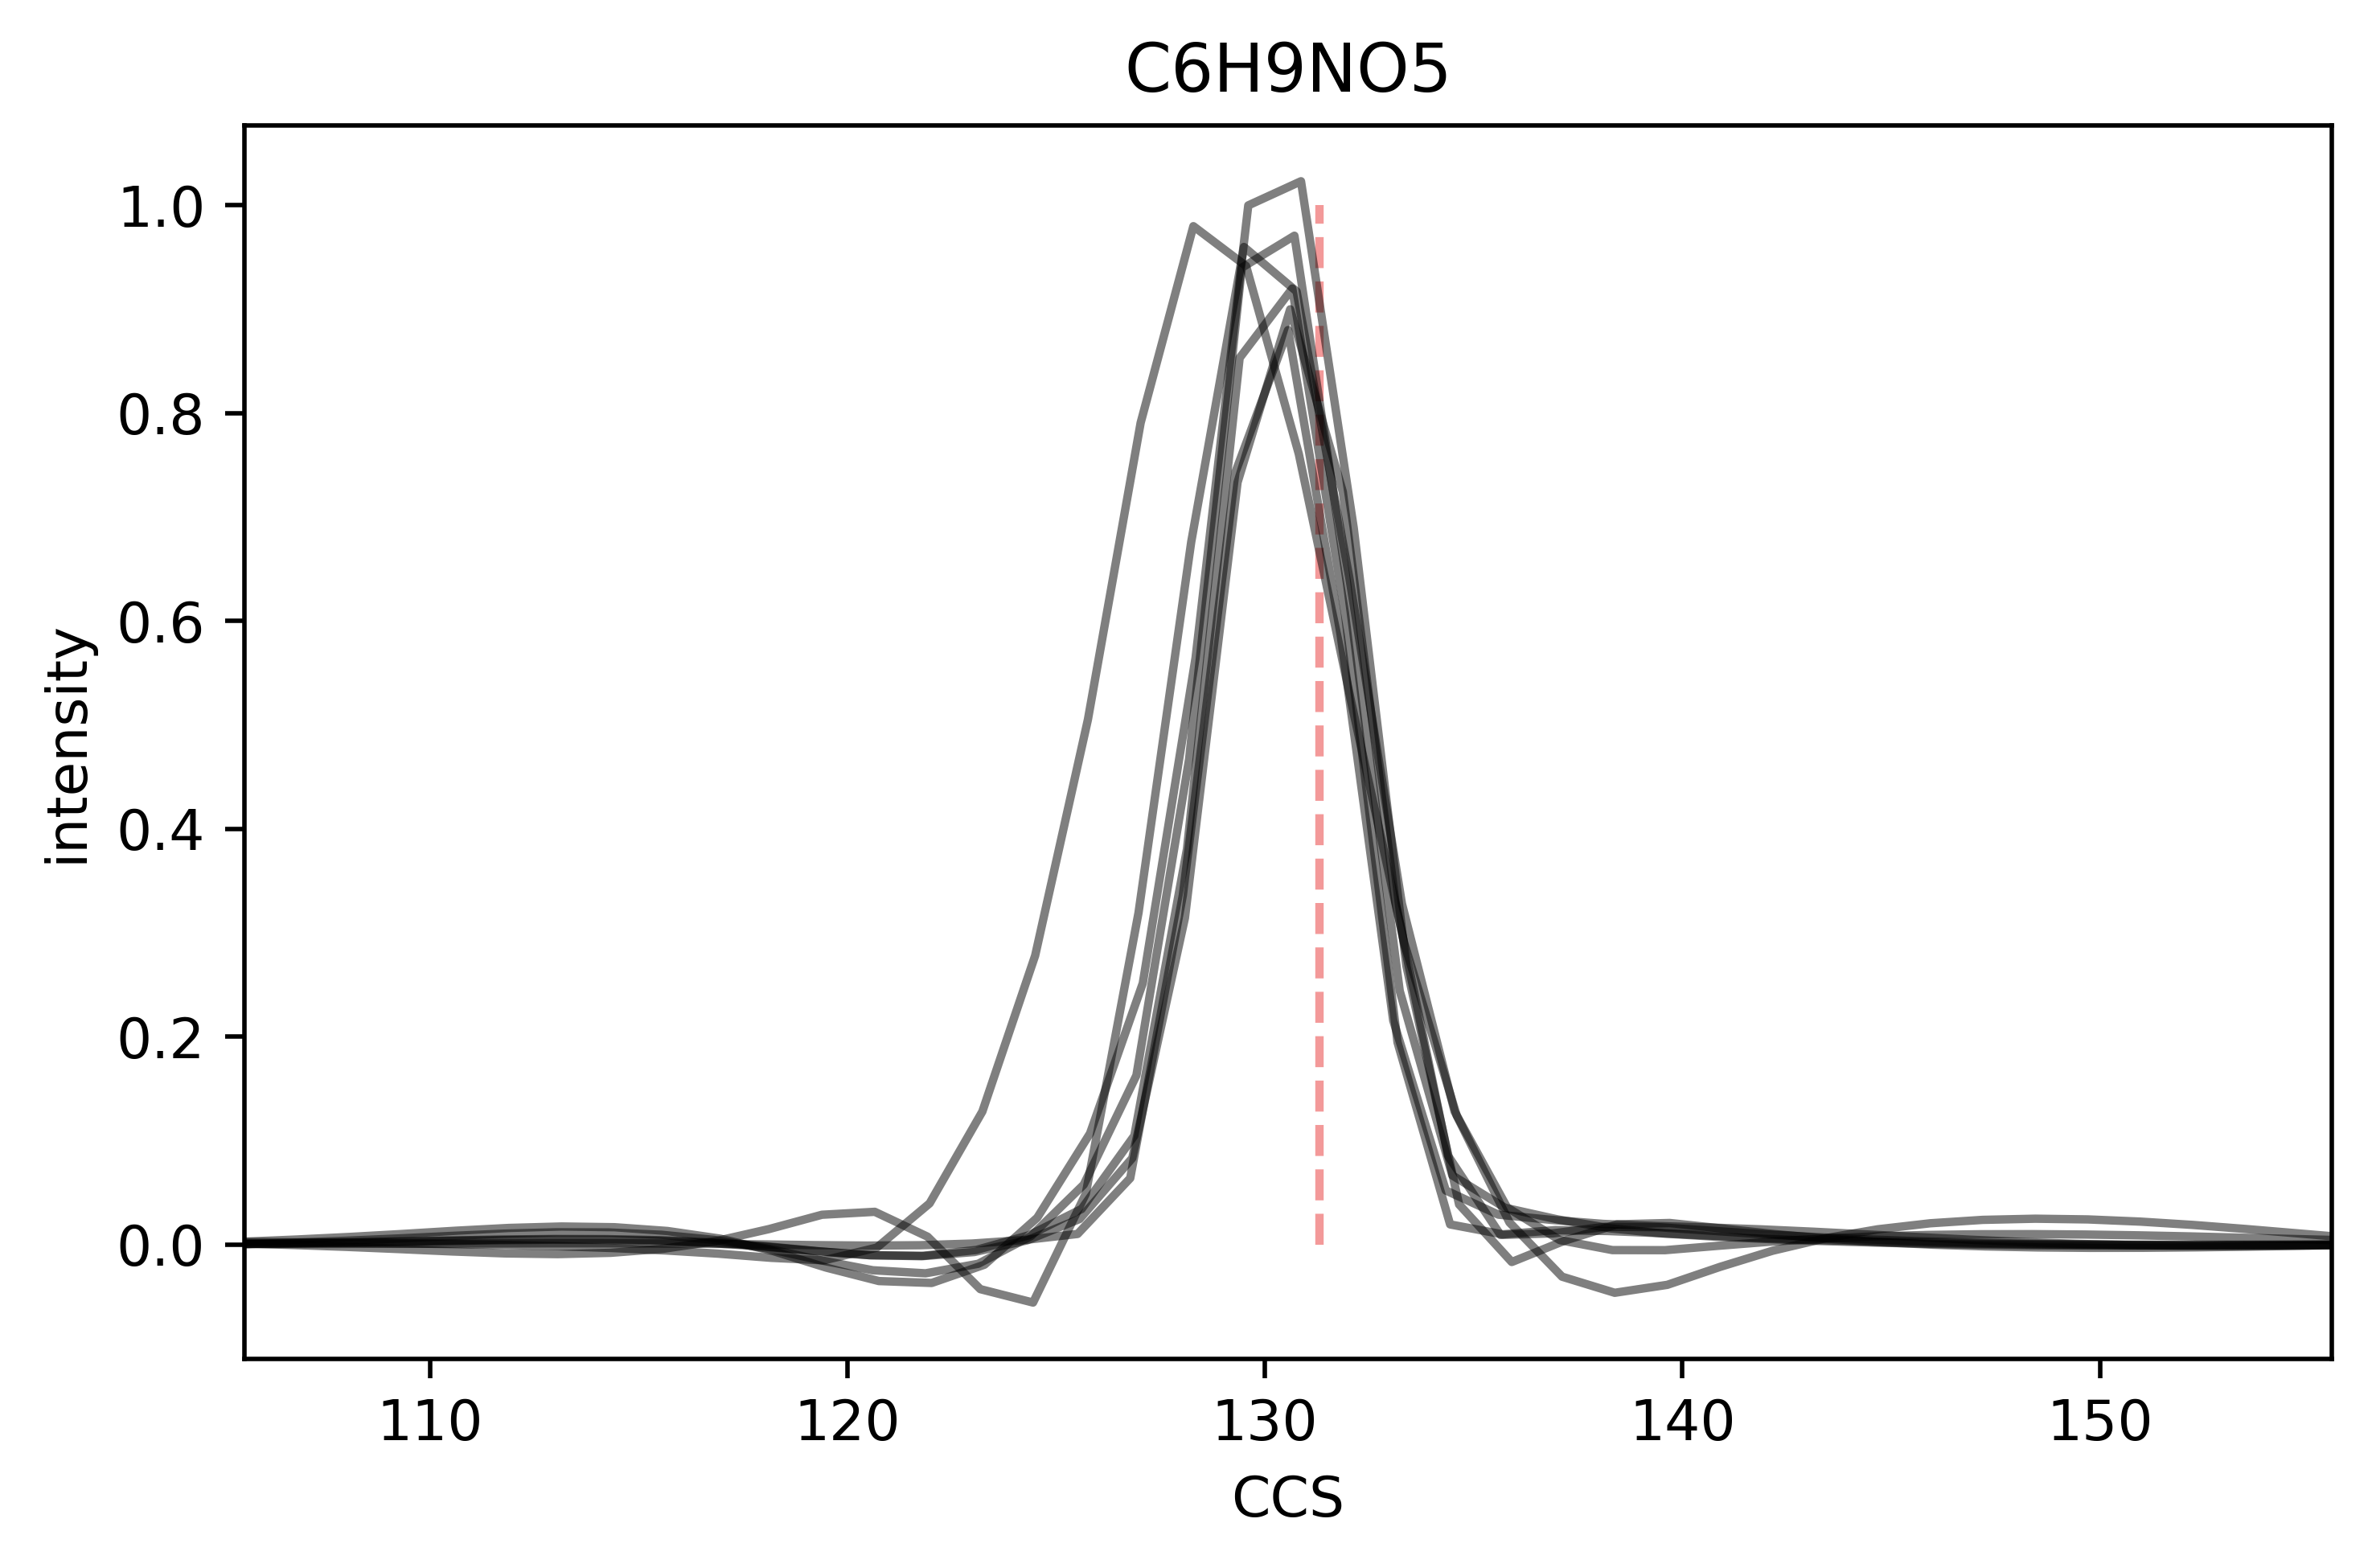

In [11]:
file = files[0]
window = 25


mob_cal_file = datadir + file.replace(".mzML",".raw/mob_cal.csv")

ccs_converted = dt2ccs(mob_cal_file)

for target in driftograms[file]:
    plt.figure()
    plt.xlabel("CCS")
    plt.ylabel("intensity")
    plt.title(target)
    plt.plot([ccs_matches[target],ccs_matches[target]],[0,1],color="lightcoral",alpha=0.8,linestyle="--")#,label="CCS Compendium Value")
    normFactor = 1.0
    counter = 0
    for mz,(intensity,times) in driftograms[file][target].items():
        times = [ccs_converted(mz,t) for t in times]
        #print(times[0],times[1])
        apex = list(range(len(intensity)))
        apex.sort(key=lambda x: intensity[x],reverse=True)
        apexInd = apex[0]
        apex = times[apexInd]
        print(target,counter,apex)
        counter += 1
        norm = np.max(intensity)
        smoothing = 0.5
        s = smoothing * len(times) * np.max(intensity)
        s = interpolate.UnivariateSpline(times, intensity,s=s)
        smoothed = [s(t) for t in times]
        smoothed = smoothed / smoothed[apexInd]
        smoothed = normFactor * smoothed
        plt.plot(times,smoothed,color="black",alpha=0.5)
        #plt.plot(times,smoothed/norm,alpha=0.5,label=mz)
        normFactor -= 0.02
    plt.xlim((apex-window,apex+window))
    plt.tight_layout()
    plt.savefig(datadir + str(target) + "_IMS.png")

        
